# CS498DL Assignment 2

In [68]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from kaggle_submission import output_submission_csv
from models.neural_net import NeuralNetwork
from models.neural_net_adam import NeuralNetwork_Adam
from utils.data_process import get_CIFAR10_data

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)  # set default size of plots

# For auto-reloading external modules
# See http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading CIFAR-10
Now that you have implemented a neural network that passes gradient checks and works on toy data, you will test your network on the CIFAR-10 dataset.

In [3]:
# You can change these numbers for experimentation
# For submission be sure they are set to the default values
TRAIN_IMAGES = 49000
VAL_IMAGES = 1000
TEST_IMAGES = 10000

data = get_CIFAR10_data(TRAIN_IMAGES, VAL_IMAGES, TEST_IMAGES)
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']

In [4]:
def get_acc(pred, y_test):
    return np.sum(y_test==pred)/len(y_test)*100

## Train using SGD or Adam
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

You can try different numbers of layers and other hyperparameters on the CIFAR-10 dataset below.

In [42]:
# Hyperparameters

input_size = 32 * 32 * 3
num_layers = 2
hidden_size = 110
hidden_sizes = [hidden_size] * (num_layers - 1)
num_classes = 10
epochs = 4000
batch_size = 200
learning_rate = 7e-2
learning_rate_decay = 0.9
regularization =  1e-2

def train(hidden_sizes, num_layers, learning_rate, learning_rate_decay, regularization, optimizer = "SGD"):
    # Initialize a new neural network model
    net = NeuralNetwork(input_size, hidden_sizes, num_classes, num_layers)
        
    # Variables to store performance for each epoch
    train_loss = np.zeros(epochs)
    train_accuracy = np.zeros(epochs)
    val_accuracy = np.zeros(epochs)
    

    # For each epoch...
    for epoch in tqdm(range(epochs)):

        batch_idx = np.random.choice(TRAIN_IMAGES, batch_size, replace=True)

        X_batch = X_train[batch_idx]
        y_batch = y_train[batch_idx]

        y_pred = np.argmax(net.forward(X_batch), axis = 1)
        train_accuracy[epoch] = get_acc(y_pred, y_batch)
        train_loss[epoch] = net.backward(X_batch, y_batch, learning_rate, regularization, mode = optimizer)

        # Validation
        # No need to run the backward pass here, just run the forward pass to compute accuracy  
        y_val_pred = np.argmax(net.forward(X_val), axis = 1)
        val_accuracy[epoch] = get_acc(y_val_pred, y_val)

        if epoch % 50 == 0:
             learning_rate *= learning_rate_decay

    return net, train_loss, train_accuracy, val_accuracy
        
net, train_loss, train_accuracy, val_accuracy = train(hidden_sizes, num_layers, learning_rate, learning_rate_decay, regularization, "Adam")


100%|██████████| 4000/4000 [02:04<00:00, 32.22it/s]

50.1


In [103]:
y_test_pred = np.argmax(net.forward(X_test), axis = 1)
test_acc = get_acc(y_test_pred, y_test)
print(test_acc)

51.65


## Graph loss and train/val accuracies

Examining the loss graph along with the train and val accuracy graphs should help you gain some intuition for the hyperparameters you should try in the hyperparameter tuning below. It should also help with debugging any issues you might have with your network.

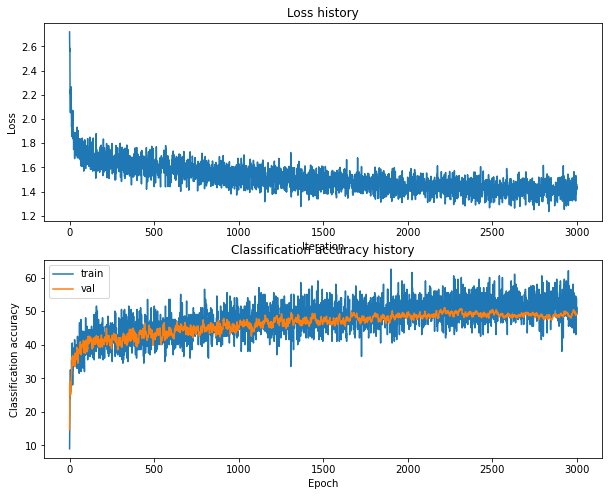

In [23]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(train_loss)
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

## Train using Adam
Next we will train the same model using the Adam optimizer. You should take the above code for SGD and modify it to use Adam instead. For implementation details, see the lecture slides. The original paper that introduced Adam is also a good reference, and contains suggestions for default values: https://arxiv.org/pdf/1412.6980.pdf

In [ ]:
# TODO: implement me

## Hyperparameter tuning

Once you have successfully trained a network you can tune your hyparameters to increase your accuracy.

Based on the graphs of the loss function above you should be able to develop some intuition about what hyperparameter adjustments may be necessary. A very noisy loss implies that the learning rate might be too high, while a linearly decreasing loss would suggest that the learning rate may be too low. A large gap between training and validation accuracy would suggest overfitting due to large model without much regularization. No gap between training and validation accuracy would indicate low model capacity. 

You will compare networks of two and three layers using the different optimization methods you implemented. 

The different hyperparameters you can experiment with are:
- **Batch size**: We recommend you leave this at 200 initially which is the batch size we used. 
- **Number of iterations**: You can gain an intuition for how many iterations to run by checking when the validation accuracy plateaus in your train/val accuracy graph.
- **Initialization** Weight initialization is very important for neural networks. We used the initialization `W = np.random.randn(n) / sqrt(n)` where `n` is the input dimension for layer corresponding to `W`. We recommend you stick with the given initializations, but you may explore modifying these. Typical initialization practices: http://cs231n.github.io/neural-networks-2/#init
- **Learning rate**: Generally from around 1e-4 to 1e-1 is a good range to explore according to our implementation.
- **Learning rate decay**: We recommend a 0.95 decay to start.
- **Hidden layer size**: You should explore up to around 120 units per layer. For three-layer network, we fixed the two hidden layers to be the same size when obtaining the target numbers. However, you may experiment with having different size hidden layers.
- **Regularization coefficient**: We recommend trying values in the range 0 to 0.1. 

Hints:
- After getting a sense of the parameters by trying a few values yourself, you will likely want to write a few for-loops to traverse over a set of hyperparameters.
- If you find that your train loss is decreasing, but your train and val accuracy start to decrease rather than increase, your model likely started minimizing the regularization term. To prevent this you will need to decrease the regularization coefficient. 

In [104]:
input_size = 32 * 32 * 3
num_layers = 2
num_classes = 10
epochs = 2000
batch_size = 200

# lrs= [1e-3]
lrs = [7e-2]
# hidden_size = [100, 110]
hidden_size = [200]
lrds = [0.9]
# lrds = [0.95, 0.9, 0.94]
regs = [1e-2]
# regs = [3e-2, 1e-1, 5e-2]

best_acc = 0
best_net = None

results = {}
for _ in range(3):
    for hs in hidden_size:
        for lr in lrs:
            for lrd in lrds:
                for reg in regs:  
                    hidden_sizes = [hs] * (num_layers - 1)
                    net, _, _, _ = train(hidden_sizes, num_layers, lr, lrd, reg, optimizer="Adam")
                    y_val_pred = np.argmax(net.forward(X_val), axis = 1)
                    val_acc= get_acc(y_val_pred, y_val)
                    if val_acc > best_acc:
                        best_net = net
                        best_acc = val_acc 
                    results[(hs, lr, lrd, reg)] = val_acc
                    print('hs %d, lr %e, lrd %f, reg %e, val accuracy: %f' % (hs, lr, lrd, reg,  val_acc))
#     for r in results:
#         (hs, lr, lrd, reg) = r
#         val_acc = results[r]
#         print('hs %d, lr %e, lrd %f, reg %e, val accuracy: %f' % (hs, lr, lrd, reg,  val_acc))
print("Best accuracy:", best_acc)

  0%|          | 2/2000 [00:00<01:40, 19.91it/s]

hs 200, lr 7.000000e-02, lrd 0.900000, reg 1.000000e-02, val accuracy: 50.750000


  0%|          | 4/2000 [00:00<01:00, 33.03it/s]

hs 200, lr 7.000000e-02, lrd 0.900000, reg 1.000000e-02, val accuracy: 50.480000


100%|██████████| 2000/2000 [11:18<00:00,  2.95it/s]   


hs 200, lr 7.000000e-02, lrd 0.900000, reg 1.000000e-02, val accuracy: 50.640000
Best accuracy: 50.74999999999999


In [96]:
y_test_pred = np.argmax(best_net.forward(X_test), axis = 1)
test_acc= get_acc(y_test_pred, y_test)
print(test_acc)

53.06999999999999


## Run on the test set
When you are done experimenting, you should evaluate your final trained networks on the test set.

In [100]:
# best_2layer_sgd_prediction = np.argmax(best_net.forward(X_test), axis = 1)
# best_3layer_sgd_prediction = np.argmax(best_net.forward(X_test), axis = 1)
# best_2layer_adam_prediction = np.argmax(best_net.forward(X_test), axis = 1)
# best_3layer_adam_prediction = np.argmax(best_net.forward(X_test), axis = 1)

## Kaggle output

Once you are satisfied with your solution and test accuracy, output a file to submit your test set predictions to the Kaggle for Assignment 2 Neural Network. Use the following code to do so:

In [101]:
# output_submission_csv('./nn_2layer_sgd_submission.csv', best_2layer_sgd_prediction)
# output_submission_csv('./nn_3layer_sgd_submission.csv', best_3layer_sgd_prediction)
# output_submission_csv('./nn_2layer_adam_submission.csv', best_2layer_adam_prediction)
# output_submission_csv('./nn_3layer_adam_submission.csv', best_3layer_adam_prediction)

## Compare SGD and Adam
Create graphs to compare training loss and validation accuracy between SGD and Adam. The code is similar to the above code, but instead of comparing train and validation, we are comparing SGD and Adam.

In [62]:
input_size = 32 * 32 * 3
num_layers = 2
hidden_size = 110
hidden_sizes = [hidden_size] * (num_layers - 1)
num_classes = 10
epochs = 5000
batch_size = 200
learning_rate = 1e-3
learning_rate_decay = 1
regularization =  1e-2


sgd_loss = np.zeros(epochs)
adam_loss = np.zeros(epochs)
sgd_accuracy = np.zeros(epochs)
adam_accuracy = np.zeros(epochs)

_, sgd_loss, _, sgd_accuracy = train(hidden_sizes, num_layers, learning_rate, learning_rate_decay, regularization, "SGD")
_, adam_loss, _, adam_accuracy = train(hidden_sizes, num_layers, learning_rate, learning_rate_decay, regularization, "Adam")



100%|██████████| 5000/5000 [02:00<00:00, 41.37it/s]


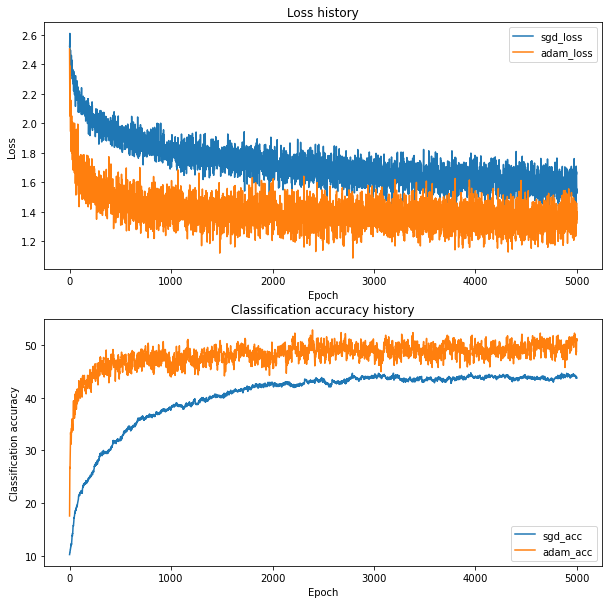

In [69]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(sgd_loss, label='sgd_loss')
plt.plot(adam_loss, label='adam_loss')
plt.title('Loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sgd_accuracy, label='sgd_acc')
plt.plot(adam_accuracy, label='adam_acc')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()